# Real-Time EEG Reading

C:\Users\Amesh\AppData\Local\Temp\ipykernel_13868\218896197.py:78: UserWarning: frames=<function main.<locals>.data_gen at 0x000001BCCB47A980> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, data_gen, init_func=init, blit = True, interval = interval)


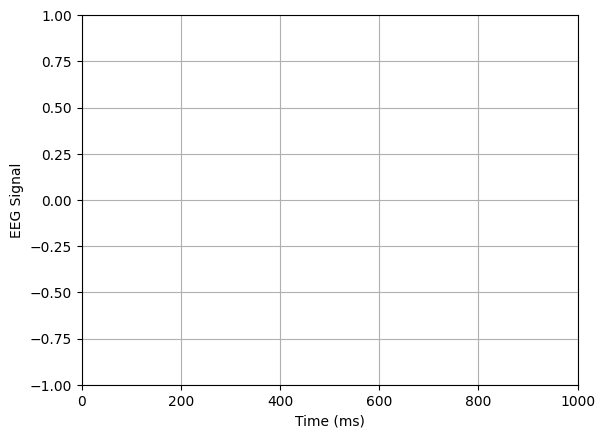

In [13]:
import numpy as np
import serial
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#Function to acquire EEG data from the serial port in real-time

def acquire_eeg_data(port = 'COM3', baudrate = 9600, timeout = 1):
    """
    Acquire EEG data from the EEG device in real-time

    Args:
        ports (str) : The serial port to which the EEG device is connected
        baudrate (int) : The baud rate for the serial communication
        timeout (int) : Timeout for the serial read
    
    Returns :
        Generator that yields EEG data samples
    """
    ser = serial.Serial(port, baudrate, timeout)

    try :
        while True:
            if ser.in_waiting > 0:
                data = ser.readline().decode('utf-8').strip()
                if data:
                    try:
                        yield float(data)
                    except ValueError:
                        continue
    except KeyboardInterrupt:
        print("Data acquisition interrupted.")
    finally:
        ser.close()
# Function to initialize the plot
def init():
    line.set_data([],[])
    return line,

# Function to update the plot
def update(data):
    t,y = data
    t_data.append(t)
    y_data.append(t)
    if len(t_data) > max_x:
        t_data.pop(0)
        y_data.pop(0)
    line.set_data(t_data, y_data)
    ax.set_xlim(max(0, t-max_x),t)
    ax.set_ylim(min(y_data)-0.1,max(y_data)+0.1)
    return line,

# Main function to run the real-time aquisition and plotting

def main(port = 'COM3', baudrate=9600, interval = 1000/256):
    global t_data, y_data, max_x
    t_data, y_data = [], []
    max_x = 1000 # Number of points to display at a time

    fig, ax = plt.subplots()

    global line 
    line, = ax.plot([],[], lw = 2)
    ax.set_xlim(0, max_x)
    ax.set_ylim(-1,1)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('EEG Signal')
    ax.grid()

    eeg_data_gen = acquire_eeg_data(port= port , baudrate=baudrate)

    def data_gen():
        t = 0
        for data in eeg_data_gen:
            yield t, data
            t +=interval
    
    ani = animation.FuncAnimation(fig, update, data_gen, init_func=init, blit = True, interval = interval)
    plt.show()

if __name__ == "__main__":
    main(port = 'COM3')
    

# Simulator

In [14]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import time
import threading
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.signal as signal
import joblib
import pickle

#function  to generate random eeg-like data
def generate_random_eeg_data(num_channels):
    while True: 
        data_point = np.random.uniform(-1,1, num_channels)
        yield data_point
        time.sleep(1/256)

# Function to create a notch filter
def create_notch_filter(freq = 50.0 , fs = 256.0, quality = 30.0):
    b,a = signal.iirnotch(freq, quality, fs)
    return b,a

# function to create a low-pass filter
def create_lowpass_filter(cutoff=50.0, fs = 256.0, order=5):
    nyquist = 0.5*fs
    normal_cutoff = cutoff/ nyquist
    b, a = signal.butter(order, normal_cutoff, btype = 'low', analog = False)
    return b, a

def fft_conversion(segment, fs = 256.0):
    fft_values = np.fft.rfft(segment)
    fft_freqs = np.fft.rfftfreq(len(segment), d = 1/fs)
    fft_vector = np.abs(fft_values)
    return fft_vector

# Load the pretrained machine learning model
model_path = "F:\Engineering\Semester 8\EE406 - Undergraduate Project 2\Saved Models\modelsvc.pkl"

with open(model_path, 'rb') as file:
    model = pickle.load(file)
# GUI Class
class EEGSimulatorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("EEG Simulation GUI")
        self.label_prediction = ttk.Label(root, text = "Predicted Class: ")
        self.label_prediction.pack(pady = 10)

        self.label_time = ttk.Label(root, text = "Time: ")
        self.label_time.pack(pady = 10)

        self.prediction_value = tk.StringVar()
        self.time_value = tk.StringVar()

        self.label_predicted_value = ttk.Label(root, textvariable=self.prediction_value, font = ("Helvetica",18))
        self.label_predicted_value.pack()

        self.label_time_value = ttk.Label(root, textvariable=self.time_value, font = ("Helvetica", 12))
        self.label_time_value.pack()

        self.running = False
        self.data_stream = generate_random_eeg_data(16)

        self.start_button = ttk.Button(root, text = "Start", command = self.start_button)
        self.start_button.pack(pady = 20)

        self.stop_button = ttk.Button(root, text = "Stop", command = self.stop_button, state=tk.DISABLED)
        self.stop_button.pack(pady = 10)
    
    def start_stream(self):
        self.running = True
        self.start_button.config(state = tk.DISABLED)
        self.stop_button.config(state = tk.NORMAL)
        threading.Thread(target=self.stream_data).start()

    def stop_stream(self):
        self.running = False 
        self.start_button.config(state=tk.NORMAL)
        self.stop_button.config(state=tk.DISABLED)

    def stream_data(self):
        while self.running:
            try:
                data_point = next(self.data_stream)
                self.process_data(data_point)
            except StopIteration:
                print("End of Data stream.")
                break
    
    def process_data(self, data):
        # Simulate filtering (notch and low-pass)
        # In real application, replace with actual filtering
        filtered_data = data #Placeholder for real filtering

        # Convert to frequency domain and create feature vector
        feature_vector = fft_conversion(np.array(filtered_data))

        # Feed feature vector to ML model
        predicted_class = model.predict([feature_vector[:192]])[0]

        # Update GUI with predicted class and current time
        current_time = time.strftime("%Y-%m-%d %H:%M:%S")
        self.update_prediction(predicted_class, current_time)

    def update_prediction(self, predicted_class, time_str):
        self.prediction_value.set(predicted_class)
        self.time_value.set(time_str)
    
# Main function to run the GUI
def main():
    root = tk.Tk()
    gui = EEGSimulatorGUI(root)
    root.mainloop()

if __name__ == "__main__":
    main()

AttributeError: 'EEGSimulatorGUI' object has no attribute 'start_button'

In [15]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import time
import threading
import scipy.signal as signal
import joblib
import pickle

# Function to generate random EEG-like data
def generate_random_eeg_data(num_channels):
    while True:
        data_point = np.random.uniform(-1, 1, num_channels)
        yield data_point
        time.sleep(1/256)

# Function to create a notch filter
def create_notch_filter(freq=50.0, fs=256.0, quality=30.0):
    b, a = signal.iirnotch(freq, quality, fs)
    return b, a

# Function to create a low-pass filter
def create_lowpass_filter(cutoff=50.0, fs=256.0, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Function to apply FFT conversion
def fft_conversion(segment, fs=256.0):
    fft_values = np.fft.rfft(segment, axis=0)
    fft_vector = np.abs(fft_values)
    return fft_vector

# Load the pretrained machine learning model
model_path = "F:\Engineering\Semester 8\EE406 - Undergraduate Project 2\Saved Models\modelsvc.pkl"

with open(model_path, 'rb') as file:
    model = pickle.load(file)

# GUI Class
class EEGSimulatorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("EEG Simulation GUI")

        self.label_prediction = ttk.Label(root, text="Predicted Class: ")
        self.label_prediction.pack(pady=10)

        self.label_time = ttk.Label(root, text="Time: ")
        self.label_time.pack(pady=10)

        self.prediction_value = tk.StringVar()
        self.time_value = tk.StringVar()

        self.label_predicted_value = ttk.Label(root, textvariable=self.prediction_value, font=("Helvetica", 18))
        self.label_predicted_value.pack()

        self.label_time_value = ttk.Label(root, textvariable=self.time_value, font=("Helvetica", 12))
        self.label_time_value.pack()

        self.running = False
        self.data_stream = generate_random_eeg_data(16)

        self.start_button = ttk.Button(root, text="Start", command=self.start_stream)
        self.start_button.pack(pady=20)

        self.stop_button = ttk.Button(root, text="Stop", command=self.stop_stream, state=tk.DISABLED)
        self.stop_button.pack(pady=10)

        self.buffer = []

    def start_stream(self):
        self.running = True
        self.start_button.config(state=tk.DISABLED)
        self.stop_button.config(state=tk.NORMAL)
        threading.Thread(target=self.stream_data).start()

    def stop_stream(self):
        self.running = False
        self.start_button.config(state=tk.NORMAL)
        self.stop_button.config(state=tk.DISABLED)

    def stream_data(self):
        while self.running:
            try:
                data_point = next(self.data_stream)
                self.process_data(data_point)
            except StopIteration:
                print("End of data stream.")
                break

    def process_data(self, data):
        # Append the data to the buffer
        self.buffer.append(data)
        if len(self.buffer) == 3 * 256:  # 3 seconds of data
            segment = np.array(self.buffer)
            self.buffer.clear()

            # Simulate filtering (notch and low-pass)
            notch_b, notch_a = create_notch_filter()
            lowpass_b, lowpass_a = create_lowpass_filter()

            # Apply notch filter
            segment = signal.lfilter(notch_b, notch_a, segment, axis=0)
            # Apply low-pass filter
            segment = signal.lfilter(lowpass_b, lowpass_a, segment, axis=0)

            # Convert to frequency domain and create feature vector
            feature_vector = fft_conversion(segment)
            feature_vector = feature_vector[:6]

            # Feed feature vector to ML model
            predicted_class = model.predict([feature_vector.flatten()])[0]

            # Update GUI with predicted class and current time
            current_time = time.strftime("%Y-%m-%d %H:%M:%S")
            self.update_prediction(predicted_class, current_time)

    def update_prediction(self, predicted_class, time_str):
        self.prediction_value.set(predicted_class)
        self.time_value.set(time_str)

# Main function to run the GUI
def main():
    root = tk.Tk()
    gui = EEGSimulatorGUI(root)
    root.mainloop()

if __name__ == "__main__":
    main()


C:\Users\Amesh\AppData\Local\Temp\ipykernel_13868\3989813401.py:38: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = animation.FuncAnimation(self.fig, self.update_plot, interval=100)


[ 0.65018945 -0.74982412 -0.08988378 -0.09949606  0.73418878 -0.52355607
 -0.98075895 -0.68014785  0.53132413  0.67543398  0.79488045  0.31057289
  0.0544412   0.17266896 -0.23165764  0.37246969]
[ 0.46596281  0.91377848  0.65282221 -0.71356528 -0.9530326  -0.79966191
  0.87555141  0.96833932  0.45239771 -0.74429947 -0.50781844 -0.32745557
 -0.00646774 -0.32173825  0.16947085  0.41768787]
[ 0.55967474  0.36467567  0.4903302   0.78986766 -0.81958455 -0.27955962
 -0.9636915   0.36343154 -0.56248461 -0.05848507  0.33111213 -0.1641451
  0.52709926  0.40151579 -0.87303069 -0.58751146]
[-0.88497284  0.63396184  0.88237924 -0.15011934 -0.81991024 -0.83504541
 -0.27986763  0.73602869 -0.90337239  0.15026991 -0.48350025  0.09515514
 -0.94792194 -0.88277608 -0.38164159 -0.16508433]
[-0.95394739  0.37469546 -0.24503678  0.12297328 -0.61403981 -0.04103803
 -0.58575322  0.96231213  0.2227278   0.5626006  -0.58862745 -0.05407571
 -0.22351979  0.67728515  0.08696222  0.45197901]
[-5.50448667e-01  3.4

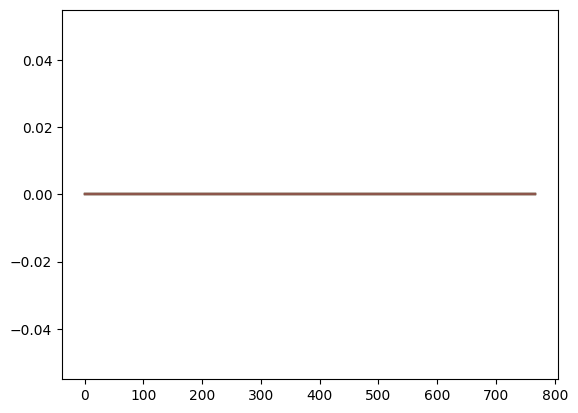

In [16]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import time
import threading
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Function to generate random EEG-like data
def generate_random_eeg_data(num_channels):
    while True:
        data_point = np.random.uniform(-1, 1, num_channels)
        print(data_point)
        yield data_point
        time.sleep(1/256)

# GUI Class
class EEGSimulatorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("EEG Simulation GUI")

        self.running = False
        self.data_stream = generate_random_eeg_data(16)

        self.start_button = ttk.Button(root, text="Start", command=self.start_stream)
        self.start_button.pack(pady=20)

        self.stop_button = ttk.Button(root, text="Stop", command=self.stop_stream, state=tk.DISABLED)
        self.stop_button.pack(pady=10)

        # Setup Matplotlib Figure and Animation
        self.fig, self.ax = plt.subplots()
        self.lines = [self.ax.plot([], [])[0] for _ in range(16)]
        self.xdata = np.arange(0, 3 * 256)
        self.ydata = np.zeros((16, 3 * 256))

        self.ani = animation.FuncAnimation(self.fig, self.update_plot, interval=100)

        # Embed Matplotlib figure into Tkinter
        self.canvas = None
        self.embed_plot()

    def start_stream(self):
        self.running = True
        self.start_button.config(state=tk.DISABLED)
        self.stop_button.config(state=tk.NORMAL)
        threading.Thread(target=self.stream_data).start()

    def stop_stream(self):
        self.running = False
        self.start_button.config(state=tk.NORMAL)
        self.stop_button.config(state=tk.DISABLED)

    def stream_data(self):
        while self.running:
            try:
                data_point = next(self.data_stream)
                self.process_data(data_point)
            except StopIteration:
                print("End of data stream.")
                break

    def process_data(self, data):
        # Shift data left and append new data point
        self.ydata = np.roll(self.ydata, -1, axis=1)
        self.ydata[:, -1] = data

    def update_plot(self, frame):
        for line, ydata in zip(self.lines, self.ydata):
            line.set_data(self.xdata, ydata)
        self.ax.relim()
        self.ax.autoscale_view()
        return self.lines

    def embed_plot(self):
        from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
        if self.canvas:
            self.canvas.get_tk_widget().pack_forget()

        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack()

# Main function to run the GUI
def main():
    root = tk.Tk()
    gui = EEGSimulatorGUI(root)
    root.mainloop()

if __name__ == "__main__":
    main()


In [17]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import time
import threading
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Function to generate random EEG Signal
def eeg_generator():
    while True:
        data_point = np.random.uniform(-1, 1)
        print(f'type : {type(data_point)}')
        print(f'shape: {data_point.shape}')
        yield data_point
        time.sleep(1/256)

# GUI Class
class EEGSimulatorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("EEG Simulation GUI")

        self.running = False
        self.data_stream = generate_random_eeg_data()

        self.start_button = ttk.Button(root, text = "Start", command = self.start_stream)
        self.start_button.pack(pady=20)

        self.stop_button = ttk.Button(root, text = "Stop", command = self.stop_stream, state = tk.DISABLED)
        self.stop_button.pack(pady = 10)

    def start_stream(self):
        self.running = True
        self.start_button.config(state = tk.DISABLED)
        self.stop_button.config(state = tk.NORMAL)
        threading.Thread(target = self.stream_data).start()

    def stop_stream(self):
        self.running = False
        self.start_button.config(state = tk.NORMAL)
        self.stop_button.config(state = tk.DISABLED)
    
    def stream_data(self):
        while self.running:
            try:
                data_point = next(self.data_stream)
                self.process_data(data_point)
            except StopIteration:
                print("End of the data stream.")
                break
    
    def process_data(self, data):
        # Shift data left and append new data point
        self.ydata = np.roll(self.ydata, -1, axis = 1)
        self.ydata[:,-1] = data

def main():
    root = tk.Tk()
    gui = EEGSimulatorGUI(root)
    root.mainloop()

if __name__ == "__main__":
    main()


TypeError: generate_random_eeg_data() missing 1 required positional argument: 'num_channels'

In [18]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import time
import threading

# Function to generate random EEG-like data
def generate_random_eeg_data(num_channels):
    while True:
        data_point = np.random.uniform(-1, 1, num_channels)
        print(data_point)
        yield data_point
        time.sleep(1/256)

# GUI Class
class EEGSimulatorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("EEG Simulation GUI")

        self.running = False
        self.data_stream = generate_random_eeg_data(16)

        self.start_button = ttk.Button(root, text="Start", command=self.start_stream)
        self.start_button.pack(pady=20)

        self.stop_button = ttk.Button(root, text="Stop", command=self.stop_stream, state=tk.DISABLED)
        self.stop_button.pack(pady=10)

        # Display Area for EEG Data
        self.data_display = tk.Text(root, height=10, width=50)
        self.data_display.pack(pady=20)

    def start_stream(self):
        self.running = True
        self.start_button.config(state=tk.DISABLED)
        self.stop_button.config(state=tk.NORMAL)
        threading.Thread(target=self.stream_data).start()

    def stop_stream(self):
        self.running = False
        self.start_button.config(state=tk.NORMAL)
        self.stop_button.config(state=tk.DISABLED)

    def stream_data(self):
        while self.running:
            try:
                data_point = next(self.data_stream)
                self.display_data(data_point)
            except StopIteration:
                print("End of data stream.")
                break

    def display_data(self, data):
        # Clear the text widget and insert new data
        self.data_display.delete('1.0', tk.END)
        self.data_display.insert(tk.END, str(data) + "\n")
        self.data_display.see(tk.END)

# Main function to run the GUI
def main():
    root = tk.Tk()
    gui = EEGSimulatorGUI(root)
    root.mainloop()

if __name__ == "__main__":
    main()
    

[ 0.09648159 -0.10713157 -0.18574329  0.88717088  0.69925793 -0.00848915
 -0.17284868  0.8368177   0.38641983 -0.31486713  0.89034931 -0.28741077
 -0.5505251  -0.60163288  0.09053867  0.45497312]
[ 0.90827136  0.90078224  0.37530036  0.24655041  0.82962908  0.3034006
  0.47573967 -0.53870498  0.37222382 -0.26796378 -0.0580891  -0.91271716
 -0.58928364 -0.69429613  0.2125066  -0.72156351]
[ 0.41075099 -0.8880065   0.19552208  0.74598475 -0.79406817 -0.5090472
 -0.00351923 -0.98258349 -0.95957746  0.8516202  -0.08287661  0.314009
  0.15719218  0.12047401 -0.68023928  0.26745983]
[-0.77000858 -0.21989364  0.44212191 -0.91982718  0.25792859 -0.27379311
 -0.93968916  0.85051386  0.93336827 -0.76882218 -0.59955172 -0.22398736
 -0.92964102 -0.55526766 -0.74193201 -0.69884259]
[ 0.16496061  0.8955283   0.60667401  0.89832934  0.26882833 -0.38164006
 -0.97813731  0.15101039  0.6662719   0.2393848   0.94879079 -0.9094746
 -0.96739092 -0.33489186 -0.63715168  0.19221289]
[-0.58507121  0.46354862 

In [19]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import time
import threading

# Function to generate random EEG-like data
def generate_random_eeg_data(num_channels):
    while True:
        data_point = np.random.uniform(-1, 1, num_channels)
        yield data_point
        time.sleep(1/256)

# GUI Class
class EEGSimulatorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("EEG Simulation GUI")

        self.running = False
        self.data_stream = generate_random_eeg_data(16)
        self.buffer = []

        self.start_button = ttk.Button(root, text="Start", command=self.start_stream)
        self.start_button.pack(pady=20)

        self.stop_button = ttk.Button(root, text="Stop", command=self.stop_stream, state=tk.DISABLED)
        self.stop_button.pack(pady=10)

        # Display Area for EEG Data
        self.data_display = tk.Text(root, height=20, width=60)
        self.data_display.pack(pady=20)

    def start_stream(self):
        self.running = True
        self.start_button.config(state=tk.DISABLED)
        self.stop_button.config(state=tk.NORMAL)
        threading.Thread(target=self.stream_data).start()

    def stop_stream(self):
        self.running = False
        self.start_button.config(state=tk.NORMAL)
        self.stop_button.config(state=tk.DISABLED)

    def stream_data(self):
        while self.running:
            try:
                data_point = next(self.data_stream)
                self.process_data(data_point)
            except StopIteration:
                print("End of data stream.")
                break

    def process_data(self, data):
        # Append data point to buffer
        self.buffer.append(data)
        
        # Check if buffer has enough data for 3 seconds
        if len(self.buffer) >= 3 * 256:
            # Create a segment
            segment = np.array(self.buffer[:3 * 256])
            self.buffer = self.buffer[3 * 256:]

            # Display the segment
            self.display_segment(segment)

    def display_segment(self, segment):
        # Clear the text widget and insert new segment
        self.data_display.delete('1.0', tk.END)
        segment_str = '\n'.join(' '.join(f'{value:.2f}' for value in row) for row in segment)
        self.data_display.insert(tk.END, segment_str + "\n")
        self.data_display.see(tk.END)

# Main function to run the GUI
def main():
    root = tk.Tk()
    gui = EEGSimulatorGUI(root)
    root.mainloop()

if __name__ == "__main__":
    main()


# Preprocessing steps


In [1]:
from sklearn.preprocessing import MinMaxScaler
def ff_transform(time_signal, frequency):

    '''- INPUTS -
    time_signal : the time domain matrix that to be converted into the fourier domain (it shoulf be in a 1D array of any size)
    frequency : the sampling frequency at which the eeg signals are captured

    OUTPUTS
    frequencies : 1D array containinf the frequencies of the output
    frequency_domain : the corresponding magnitutes are given as an array with respective to the frequencies. The output is given as a complex number
    '''
    # Perform Fourier transformation
    frequencies = np.fft.fftfreq(len(time_signal),d = 1/frequency)
    frequency_domain = np.fft.fft(time_signal)
    return frequencies, frequency_domain

def extract_harmonics(frequencies, frequency_domain, target_frequency, num_harmonics):
    ''' 
    -INPUTS
    frequencies, frequency_domain : same outputs as the ff_transform function
    target_frequency : the expected frequency, eg: when the target frequency is 5 the magnitudes of the closed components are intergrated
    num_harmonics : How many harmonics requered
    
    -OUTPUT
    returns a vector with magnitudes of the frequencies and harmonics.
    eg : if target_frequency = 5 & num_harmonics = 4
    the function outputs the magnitudes corresponding to [5,10,15,20]
    '''
    target_indices = []
    for i in range(num_harmonics):
        target_index = np.abs(frequencies-(i+1)*target_frequency).argmin()
        target_indices.append(target_index)
        #print(target_index)
    
    #feature_vector = np.zeros(num_harmonics)
    feature_vector = []
    for j in target_indices:
        feature = (frequency_domain[j] + frequency_domain[j+1] + frequency_domain[j-1] + frequency_domain[j-2]+frequency_domain[j+2])/5
        feature_vector.append(feature)
        #feature_vector[i] = feature

    #print(target_index)
    return np.array(feature_vector)

scaler = MinMaxScaler()
def all_features_per_channel(frequencies , frequency_domain, target_frequency_array, num_harmonics):
    ''' -INPUTS-
    frequencies, frequency_domain : same as the output of the ff_trainsform
    target_frequency_array : [6.5, 7,5, 8.5, 12]
    num_harmonics : 2

    - OUTPUTS
    1D array containing the features corresponds to [5,10,15,6,12,18,7,14,21,8,16,24] 
    '''
    all_features_of_channel = []
    for target_frequency in target_frequency_array:
        feature_vector = abs(extract_harmonics(frequencies,frequency_domain,target_frequency,num_harmonics))
        all_features_of_channel.append(feature_vector)
    all_features_of_channel = np.array(all_features_of_channel).flatten()
    data_2d = [[x] for x in all_features_of_channel]
    scaled_data = scaler.fit_transform(data_2d)
    all_features_of_channel = np.array([x[0] for x in scaled_data])
    all_features_of_channel_unscaled = np.array([x[0] for x in data_2d])
    return all_features_of_channel, all_features_of_channel_unscaled

def features(channel_signal,sampling_frequency,target_array, num_harmonics):
    """
    assuming that the channel_signal is in the format of (256*3, 16)
    [channel01 features, channel02 features, channel03 features, channel04 features...]
    """
    
    feeding_data = []
    feeding_data_unscaled = []
    for channel in range(channel_signal.shape[1]):
        frequencies, frequency_domain = ff_transform(channel_signal[:,channel],sampling_frequency)
        channel_features, channel_features_unscaled = all_features_per_channel(frequencies, frequency_domain, target_array, num_harmonics)
        feeding_data.append(channel_features)
        feeding_data_unscaled.append(channel_features_unscaled)
    
    feeding_array = np.concatenate(feeding_data, axis = 0).flatten()
    return feeding_array 

In [2]:
import numpy as np
import pickle

# Define the shape of the array
shape = (3*256, 16)

# Generate the random array
random_array = np.random.uniform(-1, 1, shape)
target_array = np.array([5,6,7,8])

feeding_array = features(random_array, 256, target_array, 3)
feeding_array = feeding_array.reshape(1, -1)

feeding_array.shape

# Load the pretrained machine learning model
model_path1 = "F:\Engineering\Semester 8\EE406 - Undergraduate Project 2\Saved Models\modeltrial1.pkl" #5Hz

with open(model_path1, 'rb') as file:
    model1 = pickle.load(file)

y = model1.predict(feeding_array)

array([0.])

In [3]:
def generate_random_eeg_data(num_channels):
    while True:
        data_point = np.random.uniform(-1, 1, num_channels)
        print(data_point)
        yield data_point
        time.sleep(1/256)



In [4]:
import tkinter as tk
import numpy as np
import time
import threading

# Function to generate EEG data
def generate_random_eeg_data(num_channels, stop_event):
    while not stop_event.is_set():
        data_point = np.random.uniform(-1, 1, num_channels)
        print(data_point.shape)
        time.sleep(1/256)

# GUI class
class EEGApp:
    def __init__(self, root):
        self.root = root
        self.root.title("EEG Signal Generator")
        
        self.start_button = tk.Button(root, text="Start", command=self.start_generating)
        self.start_button.pack(pady=20)
        
        self.stop_button = tk.Button(root, text="Stop", command=self.stop_generating)
        self.stop_button.pack(pady=20)
        
        self.stop_event = threading.Event()
        self.generator_thread = None
        self.num_channels = 16

    def start_generating(self):
        if self.generator_thread is None or not self.generator_thread.is_alive():
            self.stop_event.clear()
            self.generator_thread = threading.Thread(target=generate_random_eeg_data, args=(self.num_channels, self.stop_event))
            self.generator_thread.start()

    def stop_generating(self):
        self.stop_event.set()
        if self.generator_thread is not None:
            self.generator_thread.join()

# Create the main window
root = tk.Tk()
app = EEGApp(root)
root.mainloop()


(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,

In [5]:
import tkinter as tk
import numpy as np
import time
import threading
from queue import Queue

# Function to generate EEG data
def generate_random_eeg_data(num_channels, stop_event, data_queue):
    frequency = 256  # Hz
    while not stop_event.is_set():
        data_point = np.random.uniform(-1, 1, num_channels)
        data_queue.put(data_point)
        time.sleep(1 / frequency)

# Function to segment EEG data into 3-second segments
def segment_eeg_data(num_channels, stop_event, data_queue):
    segment_duration = 3  # seconds
    frequency = 256  # Hz
    target_array = np.array([5,6,7,8])
    segment_size = segment_duration * frequency  # Number of data points in 3 seconds
    segment = []


    while not stop_event.is_set():
        try:
            data_point = data_queue.get(timeout=1)
            segment.append(data_point)
            if len(segment) == segment_size:
                segment_array = np.array(segment)
                feeding_data = features(segment_array, frequency, target_array,3)
                feeding_data = feeding_data.reshape(1,-1)
                y = model.predict(feeding_data)
                print(f"prediction: {y}")
                print(f"feeding shape: {feeding_data.shape}")
                segment = []  # Reset the segment for the next 3 seconds
        except Queue.Empty:
            continue

# GUI class
class EEGApp:
    def __init__(self, root):
        self.root = root
        self.root.title("EEG Signal Generator")
        
        self.start_button = tk.Button(root, text="Start", command=self.start_generating)
        self.start_button.pack(pady=20)
        
        self.stop_button = tk.Button(root, text="Stop", command=self.stop_generating)
        self.stop_button.pack(pady=20)
        
        self.stop_event = threading.Event()
        self.generator_thread = None
        self.segmenter_thread = None
        self.num_channels = 16
        self.data_queue = Queue()

    def start_generating(self):
        if (self.generator_thread is None or not self.generator_thread.is_alive()) and (self.segmenter_thread is None or not self.segmenter_thread.is_alive()):
            self.stop_event.clear()
            self.generator_thread = threading.Thread(target=generate_random_eeg_data, args=(self.num_channels, self.stop_event, self.data_queue))
            self.segmenter_thread = threading.Thread(target=segment_eeg_data, args=(self.num_channels, self.stop_event, self.data_queue))
            self.generator_thread.start()
            self.segmenter_thread.start()

    def stop_generating(self):
        self.stop_event.set()
        if self.generator_thread is not None:
            self.generator_thread.join()
        if self.segmenter_thread is not None:
            self.segmenter_thread.join()

# Create the main window
root = tk.Tk()
app = EEGApp(root)
root.mainloop()

prediction: [0.]
feeding shape: (1, 192)


prediction: [0.]
feeding shape: (1, 192)


In [6]:
import tkinter as tk
import numpy as np
import time
import threading
from queue import Queue

# Function to generate EEG data
def generate_random_eeg_data(num_channels, stop_event, data_queue):
    frequency = 256  # Hz
    while not stop_event.is_set():
        data_point = np.random.uniform(-1, 1, num_channels)
        data_queue.put(data_point)
        time.sleep(1 / frequency)

class EEGApp:
    def __init__(self, root):
        self.root = root
        self.root.title("EEG Signal Generator")
        
        self.start_button = tk.Button(root, text="Start", command=self.start_generating)
        self.start_button.pack(pady=20)
        
        self.stop_button = tk.Button(root, text="Stop", command=self.stop_generating)
        self.stop_button.pack(pady=20)

        self.label = tk.Label(root, text="")
        self.label.pack(pady=20)
        
        self.stop_event = threading.Event()
        self.generator_thread = None
        self.segmenter_thread = None
        self.num_channels = 16
        self.data_queue = Queue()

    def start_generating(self):
        if (self.generator_thread is None or not self.generator_thread.is_alive()) and (self.segmenter_thread is None or not self.segmenter_thread.is_alive()):
            self.stop_event.clear()
            self.generator_thread = threading.Thread(target=generate_random_eeg_data, args=(self.num_channels, self.stop_event, self.data_queue))
            self.segmenter_thread = threading.Thread(target=self.segment_eeg_data_wrapper)
            self.generator_thread.start()
            self.segmenter_thread.start()

    def stop_generating(self):
        self.stop_event.set()
        if self.generator_thread is not None:
            self.generator_thread.join()
        if self.segmenter_thread is not None:
            self.segmenter_thread.join()

    def segment_eeg_data_wrapper(self):
        self.segmenter_thread = threading.Thread(target=segment_eeg_data, args=(self.num_channels, self.stop_event, self.data_queue, self.label))
        self.segmenter_thread.start()

def segment_eeg_data(num_channels, stop_event, data_queue, label):
    segment_duration = 3  # seconds
    frequency = 256  # Hz
    target_array = np.array([5, 6, 7, 8])
    segment_size = segment_duration * frequency  # Number of data points in 3 seconds
    segment = []
    while not stop_event.is_set():
        try:
            data_point = data_queue.get(timeout=1)
            segment.append(data_point)
            if len(segment) == segment_size:
                segment_array = np.array(segment)
                feeding_data = features(segment_array, frequency, target_array, 3)
                feeding_data = feeding_data.reshape(1, -1)
                y = model.predict(feeding_data)
                current_time = time.strftime("%H:%M:%S")
                label.config(text=f"Prediction: {y}, Time: {current_time}")
                segment = []  # Reset the segment for the next 3 seconds
        except Queue.Empty:
            continue

# Create the main window
root = tk.Tk()
app = EEGApp(root)
root.mainloop()


prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)


prediction: [0.]
feeding shape: (1, 192)


Exception in thread Thread-10 (segment_eeg_data):
Traceback (most recent call last):
  File "C:\Users\Amesh\AppData\Local\Temp\ipykernel_13792\117781707.py", line 70, in segment_eeg_data
  File "c:\Users\Amesh\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 1702, in configure
    return self._configure('configure', cnf, kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Amesh\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 1692, in _configure
    self.tk.call(_flatten((self._w, cmd)) + self._options(cnf))
RuntimeError: main thread is not in main loop

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Amesh\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\Amesh\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)


prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [1.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]
feeding shape: (1, 192)
prediction: [0.]